# Predicting In-Hospital Mortality for Diabetic ICU Patients

### Step 1: Import all required libraries

In [2]:
#############################################
### Step 1: Import all required libraries ###
#############################################

print("-== STEP 1: Importing all required libraries ==-")

# Data initial processing
import pandas as pd
import duckdb
import numpy as np

# skikit-learn for Logistic Regression and Random Forest
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import class_weight
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, ConfusionMatrixDisplay

# Extra Classifiers for test, more complex ones
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns


-== STEP 1: Importing all required libraries ==-


### Step 2: Loading Data from MIMIC III DuckDB Database

In [3]:
############################################################
### Step 2: Loading Data from MIMIC III DuckDB Database  ###
############################################################

print("-== STEP 2: Function for loading data into pandas DataFrame from DuckDB ==-")

DB_FILE = 'MIMICIII.duckdb'

def execute_sql(query: str, db_file: str = DB_FILE, read_only: str = True) -> pd.DataFrame:
    with duckdb.connect(db_file, read_only=read_only) as con:
        res = con.execute(query).df()
    return res
    

-== STEP 2: Function for loading data into pandas DataFrame from DuckDB ==-


### Step 3: Filtering required data in DuckDB and loading to final DataFrame

In [48]:
################################################################################
### Step 3: Filtering required data in DuckDB and loading to final DataFrame ###
################################################################################

print("-== STEP 3: Utilizing SQL Query to load required data into pandas ==-")

sql_query = """
WITH 
    -- THIS QUERY FILTER ALL PATIENTS WITH DIABETES, AS IT STARTS WITH 250.... IN ICD9 CODE --
    PATIENTS_WITH_DIABET AS (
        SELECT DISTINCT 
            hadm_id
        FROM
            diagnoses_icd
        WHERE
            icd9_code LIKE '250%'
    ),
    -- THIS QUERY FILTER FIRST STAY IN ICU FOR PATIENTS WITH DIABETES --
    FIRST_STAY_ICU AS (
        SELECT
            p.subject_id,
            a.hadm_id,
            i.icustay_id,
            p.gender,
            a.admission_type,
            a.insurance,
            a.marital_status,
            a.ethnicity,
            s.curr_service,
            CAST(strftime('%Y', a.admittime) AS INT) - CAST(strftime('%Y', p.dob) AS INT) AS age,
            i.intime,
            i.outtime,
            CASE
                WHEN p.dod IS NOT NULL AND p.dod BETWEEN a.admittime AND a.dischtime THEN 1
                ELSE 0
            END AS in_hospital_mortality,
            ROW_NUMBER() OVER(PARTITION BY a.hadm_id ORDER BY i.intime) as icu_rank
        FROM 
            patients p
            JOIN admissions a ON p.subject_id = a.subject_id
            JOIN icustays i ON a.hadm_id = i.hadm_id
            LEFT JOIN services s ON a.hadm_id = s.hadm_id AND s.transfertime = (SELECT MIN(transfertime) FROM services WHERE hadm_id = a.hadm_id)
        WHERE
            a.hadm_id IN (SELECT hadm_id FROM PATIENTS_WITH_DIABET)
    ),
    -- THIS QUERY AGGREGATES/CALCULATES FILTERED ABOVE PATIENT VITAL SIGNS --
    PATIENT_FIRST_DAY_AVG_METRICS AS (
        SELECT
            fsi.icustay_id,
            AVG(CASE WHEN itemid IN (211, 220045) THEN valuenum ELSE NULL END) AS heart_rate_mean,
            AVG(CASE WHEN itemid IN (51, 442, 455, 6701, 220179, 220050) THEN valuenum ELSE NULL END) AS sbp_mean,
            AVG(CASE WHEN itemid IN (8368, 8440, 8441, 8555, 220180, 220051) THEN valuenum ELSE NULL END) AS dbp_mean,
            AVG(CASE WHEN itemid IN (618, 615, 220210, 224690) THEN valuenum ELSE NULL END) AS resp_rate_mean,
            AVG(CASE WHEN itemid IN (223762, 676, 677, 678, 679) THEN valuenum ELSE NULL END) AS temp_c_mean
        FROM
            FIRST_STAY_ICU fsi
            JOIN chartevents ce ON fsi.icustay_id = ce.icustay_id
        WHERE
            fsi.icu_rank = 1
            AND ce.charttime BETWEEN fsi.intime AND (fsi.intime + INTERVAL '24' HOUR)
        GROUP BY
            fsi.icustay_id
    ),
    -- THIS QUERY AGGREGATES/CALCULATES FILTERED ABOVE PATIENT LAB RESULTS IN FIRST 24 HOURS --
    PATIENT_FIRST_DAY_LAB_RESULTS AS (
        SELECT
            fsi.icustay_id,
            AVG(CASE WHEN itemid IN (50931, 50809) THEN valuenum ELSE NULL END) AS glucose_mean,
            MIN(CASE WHEN itemid IN (50931, 50809) THEN valuenum ELSE NULL END) AS glucose_min,
            MAX(CASE WHEN itemid IN (50931, 50809) THEN valuenum ELSE NULL END) AS glucose_max,
            AVG(CASE WHEN itemid = 51006 THEN valuenum ELSE NULL END) AS bun_mean,
            AVG(CASE WHEN itemid = 50912 THEN valuenum ELSE NULL END) AS creatinine_mean,
            AVG(CASE WHEN itemid IN (51301, 51300) THEN valuenum ELSE NULL END) AS wbc_mean,
            AVG(CASE WHEN itemid = 50813 THEN valuenum ELSE NULL END) AS lactate_mean
        FROM 
            FIRST_STAY_ICU fsi
            JOIN labevents le ON fsi.hadm_id = le.hadm_id
        WHERE
            fsi.icu_rank = 1
            AND le.charttime BETWEEN fsi.intime AND (fsi.intime + INTERVAL '24' HOUR)
        GROUP BY
            fsi.icustay_id
)
-- THIS IS MAIN AND FINAL SELECT --
SELECT
    fsi.age,
    fsi.gender,
    fsi.admission_type,
    fsi.insurance,
    fsi.marital_status,
    fsi.ethnicity,
    fsi.curr_service,
    fsi.in_hospital_mortality,
    pm.heart_rate_mean,
    pm.sbp_mean,
    pm.dbp_mean,
    pm.resp_rate_mean,
    pm.temp_c_mean,
    plab.glucose_mean,
    plab.glucose_min,
    plab.glucose_max,
    plab.bun_mean,
    plab.creatinine_mean,
    plab.wbc_mean,
    plab.lactate_mean
FROM 
    FIRST_STAY_ICU fsi
    LEFT JOIN PATIENT_FIRST_DAY_AVG_METRICS pm ON fsi.icustay_id = pm.icustay_id
    LEFT JOIN PATIENT_FIRST_DAY_LAB_RESULTS plab ON fsi.icustay_id = plab.icustay_id
WHERE
    fsi.icu_rank = 1
    AND fsi.age BETWEEN 16 AND 120;
"""

print("\n[START] Loading....")
df = execute_sql(sql_query)
print(f"\n[END] Data extraction complete. Found {len(df)} ICU stays.")
print("\nTop 10 records:")
df.head(10)

-== STEP 3: Utilizing SQL Query to load required data into pandas ==-

[START] Loading....

[END] Data extraction complete. Found 13348 ICU stays.

Top 10 records:


,age,GENDER,ADMISSION_TYPE,INSURANCE,MARITAL_STATUS,ETHNICITY,CURR_SERVICE,in_hospital_mortality,heart_rate_mean,sbp_mean,dbp_mean,resp_rate_mean,temp_c_mean,glucose_mean,glucose_min,glucose_max,bun_mean,creatinine_mean,wbc_mean,lactate_mean
0,35,F,EMERGENCY,Private,DIVORCED,WHITE,MED,0,111.760000,177.041667,90.666667,16.875000,NaN,151.000000,123.0,185.0,37.750000,2.30,10.80,NaN
1,37,F,EMERGENCY,Medicaid,DIVORCED,WHITE,SURG,0,99.652174,123.928571,54.857143,16.636364,68.867682,131.000000,120.0,142.0,13.000000,1.20,25.75,0.90
2,50,M,EMERGENCY,Medicaid,SINGLE,WHITE,CMED,0,69.823529,105.937500,70.375000,22.000000,68.091663,113.000000,113.0,113.0,14.000000,1.00,5.70,NaN
3,54,F,EMERGENCY,Private,SINGLE,HISPANIC OR LATINO,SURG,0,83.714286,105.263158,48.368421,15.809524,NaN,207.000000,207.0,207.0,7.000000,0.80,8.90,NaN
4,64,M,EMERGENCY,Medicare,SINGLE,UNKNOWN/NOT SPECIFIED,CMED,0,76.750000,102.833333,64.625000,16.916667,68.593331,144.000000,144.0,144.0,35.000000,5.50,11.70,NaN
5,40,M,EMERGENCY,Private,MARRIED,WHITE,MED,0,92.583333,102.125000,61.916667,24.750000,NaN,205.500000,157.0,254.0,9.000000,0.75,12.90,NaN
6,74,F,EMERGENCY,Medicare,DIVORCED,WHITE,MED,0,105.666667,112.857143,54.285714,15.274510,66.581485,102.000000,83.0,117.0,38.666667,5.10,9.60,NaN
7,85,F,EMERGENCY,Private,DIVORCED,WHITE,SURG,0,90.416667,117.708333,50.541667,22.235294,68.548607,152.000000,152.0,152.0,39.000000,1.00,6.30,3.32
8,51,M,EMERGENCY,Private,MARRIED,WHITE,SURG,0,100.727273,97.217391,50.086957,19.636364,68.448158,138.000000,91.0,165.0,8.000000,1.00,17.25,NaN
9,39,F,EMERGENCY,Private,MARRIED,WHITE,MED,0,120.391304,98.608696,59.304348,17.217391,67.294449,199.666667,131.0,253.0,12.000000,0.80,13.60,NaN


### Step 4: Exploratory Data Analysis - Correlation Matrix

-== STEP 4: Correlation Matrix ==-


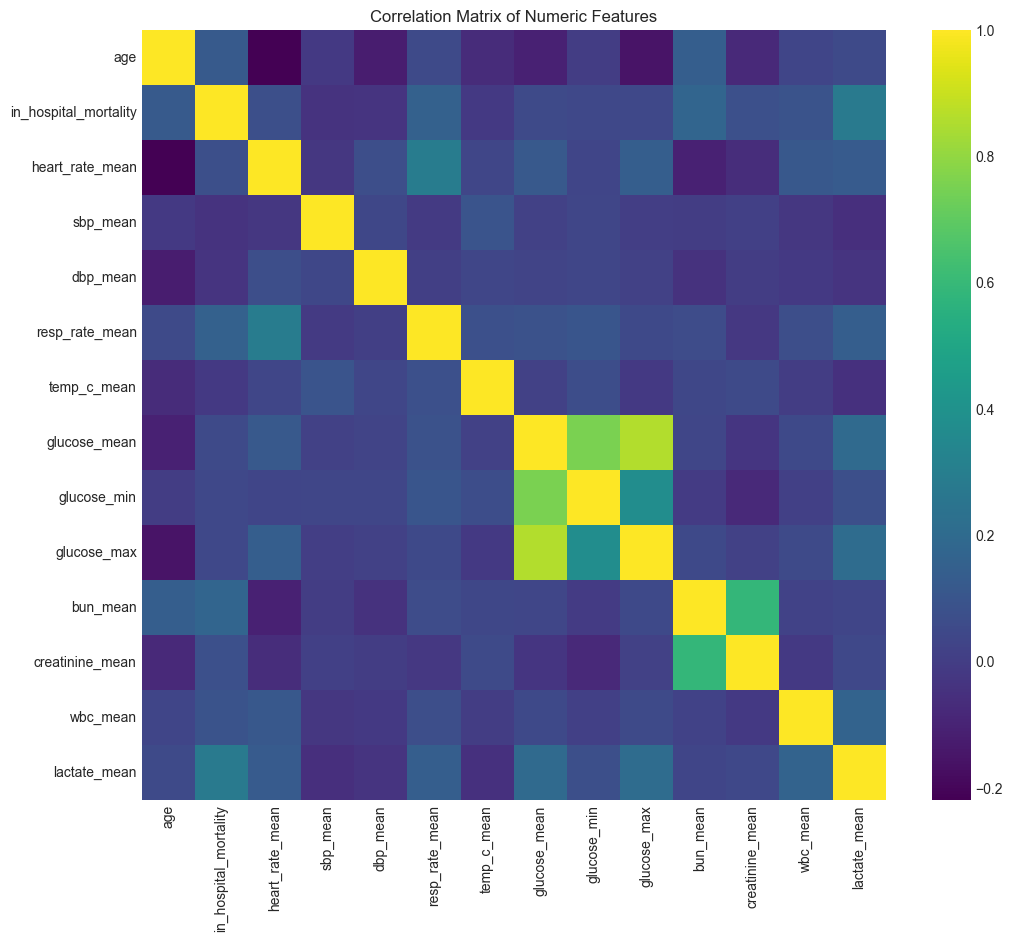

In [9]:
##############################################################
### Step 4: Exploratory Data Analysis - Correlation Matrix ###
##############################################################

print("-== STEP 4: Correlation Matrix ==-")

plt.figure(figsize=(12, 10))

# Select only numeric columns for correlation
numeric_df = df.select_dtypes(include=np.number)
correlation_matrix = numeric_df.corr()
sns.heatmap(correlation_matrix, annot=False, cmap='viridis')
plt.title('Correlation Matrix of Numeric Features')
plt.show()


### Step 5: Data Cleaning and Preprocessing

In [16]:
###############################################
### Step 5: Data Cleaning and Preprocessing ###
###############################################

print("-== STEP 5: Data Cleaning and Preprocessing ==-")

# 'in_hospital_mortality' is out target variable
X = df.drop('in_hospital_mortality', axis=1)
y = df['in_hospital_mortality']

numeric_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(exclude=np.number).columns.tolist()

print(f"\nNumeric features: {numeric_features}")
print(f"\nCategorical features: {categorical_features}")

# Pipeline with ColumnTransformer to apply different transformations to different columns
preprocessor_ct = ColumnTransformer(
    transformers=[
        (
            'num',
            Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                            ('scaler', StandardScaler())]),
            numeric_features),
        (
            'cat',
            Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))]),
            categorical_features)
    ],
    remainder='passthrough'
)

# Splitting Dataset to Training and Testing with 80%-20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=77, stratify=y)

# Preprocess our data with preprocessor of column transformer pipeline above
X_train_processed = preprocessor_ct.fit_transform(X_train)
X_test_processed = preprocessor_ct.transform(X_test)

print("\nFirst 10 rows of preprocessed (scaled/encoded) training data:")
pd.DataFrame(X_train_processed, columns=preprocessor_ct.get_feature_names_out()).head(10)

-== STEP 5: Data Cleaning and Preprocessing ==-

Numeric features: ['age', 'heart_rate_mean', 'sbp_mean', 'dbp_mean', 'resp_rate_mean', 'temp_c_mean', 'glucose_mean', 'glucose_min', 'glucose_max', 'bun_mean', 'creatinine_mean', 'wbc_mean', 'lactate_mean']

Categorical features: ['GENDER', 'ADMISSION_TYPE', 'INSURANCE', 'MARITAL_STATUS', 'ETHNICITY', 'CURR_SERVICE']

First 10 rows of preprocessed (scaled/encoded) training data:


,num__age,num__heart_rate_mean,num__sbp_mean,num__dbp_mean,num__resp_rate_mean,num__temp_c_mean,num__glucose_mean,num__glucose_min,num__glucose_max,num__bun_mean,...,cat__CURR_SERVICE_NSURG,cat__CURR_SERVICE_OBS,cat__CURR_SERVICE_OMED,cat__CURR_SERVICE_ORTHO,cat__CURR_SERVICE_PSURG,cat__CURR_SERVICE_SURG,cat__CURR_SERVICE_TRAUM,cat__CURR_SERVICE_TSURG,cat__CURR_SERVICE_VSURG,cat__CURR_SERVICE_None
0,-0.617879,0.565909,-0.196632,-0.008854,-0.721919,0.187119,-1.084108,-0.897551,-0.885782,-0.106964,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.032434,-0.766975,0.346635,0.599784,0.628407,0.153546,0.768360,1.405703,0.130830,-0.646799,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.116289,-1.821331,0.409448,-0.274360,-1.295261,0.187119,0.729605,1.061934,0.276060,0.173750,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.032434,-1.896278,-0.182833,-1.086842,-1.225235,0.187119,-0.704313,-0.227201,-0.788962,0.001003,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,-1.701734,-0.707219,-0.067764,-0.711807,-1.317917,0.214190,-1.239126,-0.880363,-1.089104,0.324904,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
5,0.321462,-0.536644,-0.328300,-0.439878,0.378496,0.128278,-0.440782,0.065003,-0.624367,-0.258118,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.465976,0.105016,0.051928,-0.308991,-0.506542,0.187119,-0.076489,0.219699,-0.256451,0.389684,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.899518,-1.168231,0.261851,-0.536137,-0.564209,0.066186,-0.293515,-0.089693,-0.353271,-0.603612,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,-1.123678,0.461503,0.119788,0.138124,-0.032596,0.187119,1.605458,0.907238,1.457265,-0.387678,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,-0.039823,0.252287,-0.294313,-0.413492,-0.517675,-0.116830,0.072716,-0.038128,0.217968,-0.171744,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Step 6: Fix inbalanced issue with Dataset

In [21]:
#################################################
### Step 6: Fix inbalanced issue with Dataset ###
#################################################

print("-== STEP 6: Apply custom weights as we have inbalanced Dataset ==-")

# Manual Class Weight Calculation
weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = {
    0: weights[0],
    1: weights[1]
}

print(f"\n Weight class with '0': {float(class_weights[0])}")
print(f"\n Weight class with '1': {float(class_weights[1])}")

-== STEP 6: Apply custom weights as we have inbalanced Dataset ==-

 Weight class with '0': 0.5542981727574751

 Weight class with '1': 5.104206500956023


### Step 7: Train several models and compare AUC

In [23]:
####################################################
### Step 7: Train several models and compare AUC ###
####################################################

print("-== STEP 7: Training simple and more complex models and comparing their performance ==-")

# Models and their parameters selected (most is default), with added class weights calculated above
models = {
    'Logistic Regression': LogisticRegression(random_state=77, solver='liblinear', class_weight=class_weights),
    'Random Forest': RandomForestClassifier(random_state=77, n_jobs=-1, class_weight=class_weights),
    'XGBoost': XGBClassifier(random_state=77, eval_metric='logloss', scale_pos_weight=class_weights[1]/class_weights[0]),
    'CatBoost': CatBoostClassifier(random_state=77, verbose=0, scale_pos_weight=class_weights[1]/class_weights[0])
}

# Running training (fit) and testing (predict_proba). Also calculating AUC (Area Under the Curve) for each model
print("\n MODEL PERFORMANCE:")
results = {}
for name, model in models.items():
    model.fit(X_train_processed, y_train)
    y_pred_proba = model.predict_proba(X_test_processed)[:, 1]
    auc = roc_auc_score(y_test, y_pred_proba)
    results[name] = {'auc': auc, 'model': model}
    print(f"AUC for {name}: {auc:.4f}")

-== STEP 7: Training simple and more complex models and comparing their performance ==-

 MODEL PERFORMANCE:
AUC for Logistic Regression: 0.7931
AUC for Random Forest: 0.7907
AUC for XGBoost: 0.7670
AUC for CatBoost: 0.7998


### Step 8: Checking THE BEST performed model and getting Feature Importance from it

-== STEP 8.1: Checking THE BEST performed model ==-
THE BEST MODEL: CatBoost

-== STEP 8.2: Checking Feature Importance ==-


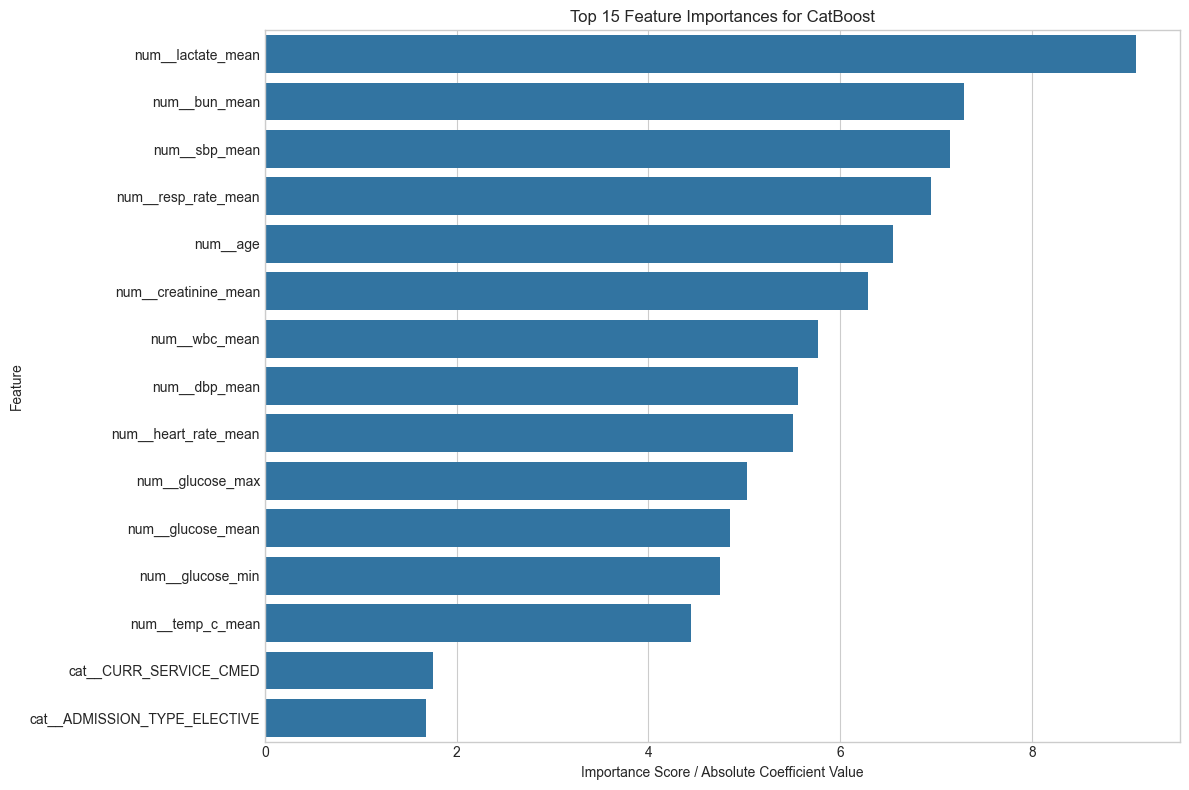

In [26]:
########################################################################################
### Step 8: Checking THE BEST performed model and getting Feature Importance from it ###
########################################################################################

print("-== STEP 8.1: Checking THE BEST performed model ==-")

best_model_name = max(results, key=lambda name: results[name]['auc'])
best_model = results[best_model_name]['model']
print(f"THE BEST MODEL: {best_model_name}")

print("\n-== STEP 8.2: Checking Feature Importance ==-")

# Get importances - different models have different parameters, so we add this tweak to cover that
importances = []
if hasattr(best_model, 'feature_importances_'):
    importances = best_model.feature_importances_
elif hasattr(best_model, 'coef_'):
    importances = np.abs(best_model.coef_[0])

# Prepare DataFrame for visualization
feature_importance_df = pd.DataFrame({
    'feature': preprocessor_ct.get_feature_names_out(), # column_names
    'importance': importances
}).sort_values('importance', ascending=False).head(15)

# Plotting the results
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importance_df)
plt.title(f'Top 15 Feature Importances for {best_model_name}')
plt.xlabel('Importance Score / Absolute Coefficient Value')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


### Step 9: Hyperparameter Tuning with GridSearchCV: Logistic Regression and Random Forest

In [34]:
##############################################################################################
### Step 9: Hyperparameter Tuning with GridSearchCV: Logistic Regression and Random Forest ###
##############################################################################################

print("-== STEP 9: Hyperparameter Tuning: Logistic Regression and Random Forest ==-")

print("\n-== STEP 9.1: Tuning Logistic Regression... ==-")
param_grid_lr = {
    'C': [0.01, 0.1, 0.5, 1, 5, 10],
    'penalty': ['l1', 'l2']
}
lr = LogisticRegression(random_state=77, solver='liblinear', class_weight=class_weights)
grid_search_lr = GridSearchCV(lr, param_grid_lr, cv=5, scoring='roc_auc', n_jobs=8, verbose=1)
grid_search_lr.fit(X_train_processed, y_train)
print(f"Best Logistic Regression Params: {grid_search_lr.best_params_}")
print(f"Tuned Logistic Regression AUC: {grid_search_lr.best_score_}")
results['Tuned Logistic Regression'] = {
    'auc': grid_search_lr.best_score_,
    'model': grid_search_lr.best_estimator_
}

print("\n-== STEP 9.2: Tuning Random Forest... ==-")
print("note: that took a while, as there a lot of different runs")
param_grid_rf = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 3, 5, 10],
    'min_samples_leaf': [1, 2, 3, 5, 10],
    'bootstrap': [True, False]
}
rf = RandomForestClassifier(random_state=77, n_jobs=8, class_weight='balanced')  # Let's use it for compare inbalanced data
grid_search_rf = GridSearchCV(rf, param_grid_rf, cv=3, scoring='roc_auc', n_jobs=8, verbose=1)
grid_search_rf.fit(X_train_processed, y_train)
print(f"Best Random Forest Params: {grid_search_rf.best_params_}")
print(f"Tuned Random Forest AUC: {grid_search_rf.best_score_}")
results['Tuned Random Forest'] = {
    'auc': grid_search_rf.best_score_,
    'model': grid_search_rf.best_estimator_
}


-== STEP 9: Hyperparameter Tuning: Logistic Regression and Random Forest ==-

-== STEP 9.1: Tuning Logistic Regression... ==-
Best Logistic Regression Params: {'C': 0.5, 'penalty': 'l1'}
Tuned Logistic Regression AUC: 0.8158322650652885

-== STEP 9.2: Tuning Random Forest... ==-
note: that took a while, as there a lot of different runs
Best Random Forest Params: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 400}
Tuned Random Forest AUC: 0.8252601195799149


### Step 10: Checking THE BEST performed model, including Tuned ones

In [35]:
########################################################################
### Step 10: Checking THE BEST performed model, including Tuned ones ###
########################################################################

print("-== STEP 10: Checking THE BEST performed model OVERALL ==-")

best_model_name = max(results, key=lambda name: results[name]['auc'])
best_model = results[best_model_name]['model']
print(f"THE BEST MODEL: {best_model_name}")


-== STEP 10: Checking THE BEST performed model OVERALL ==-
THE BEST MODEL: Tuned Random Forest


### Step 11: Plotting ROC Curves for all models

-== STEP 11: Plotting ROC Curves for all models ==-


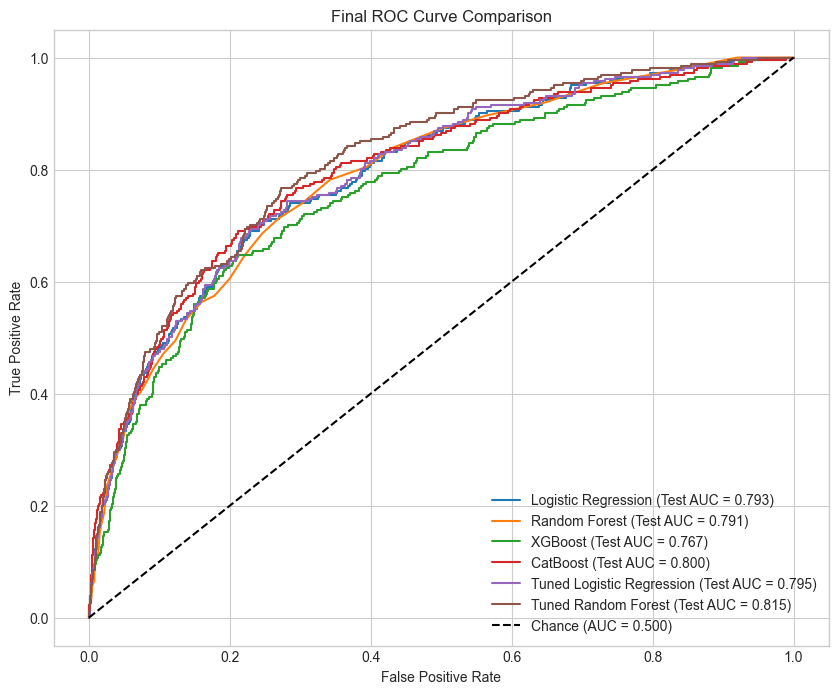

In [36]:
###################################################
### Step 11: Plotting ROC Curves for all models ###
###################################################

print("-== STEP 11: Plotting ROC Curves for all models ==-")

plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(10, 8))
for name, result in results.items():
    y_pred_proba = result['model'].predict_proba(X_test_processed)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    ax.plot(fpr, tpr, label=f"{name} (Test AUC = {roc_auc_score(y_test, y_pred_proba):.3f})")
ax.plot([0, 1], [0, 1], 'k--', label='Chance (AUC = 0.500)')
ax.set_xlabel('False Positive Rate'); ax.set_ylabel('True Positive Rate')
ax.set_title('Final ROC Curve Comparison'); ax.legend(loc='lower right'); plt.show()


### Step 12: Classification Report and Confusion Matrix

-== STEP 12: Classification Report and Confusion Matrix ==-

-== STEP 12.1: Detailed Report for Tuned Random Forest ==-
              precision    recall  f1-score   support

    Survived       0.91      0.99      0.95      2409
        Died       0.58      0.15      0.23       261

    accuracy                           0.91      2670
   macro avg       0.75      0.57      0.59      2670
weighted avg       0.88      0.91      0.88      2670


-== STEP 12.2: Tuned Random Forest Confusion Matrix ==-


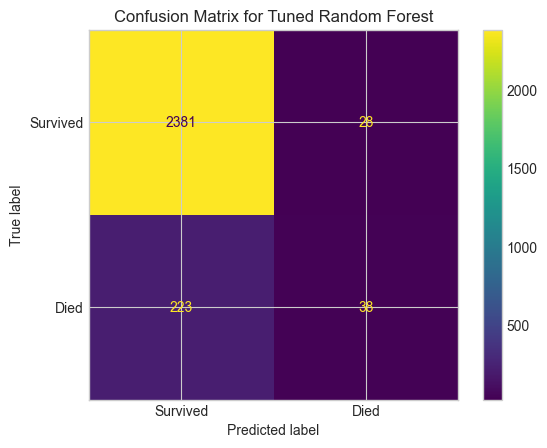

In [46]:
###########################################################
### Step 12: Classification Report and Confusion Matrix ###
###########################################################

print("-== STEP 12: Classification Report and Confusion Matrix ==-")

# NOTE: This is for Random Forest without weights! Like treat Balanced DataFrame
print(f"\n-== STEP 12.1: Detailed Report for {best_model_name} ==-")
y_pred_class = best_model.predict(X_test_processed)
print(classification_report(y_test, y_pred_class, target_names=['Survived', 'Died']))

print(f"\n-== STEP 12.2: {best_model_name} Confusion Matrix ==-")
ConfusionMatrixDisplay.from_estimator(best_model, X_test_processed, y_test, display_labels=['Survived', 'Died'])
plt.title(f'Confusion Matrix for {best_model_name}')
plt.show()


-== STEP 12.3: Detailed Report for CatBoost ==-
              precision    recall  f1-score   support

    Survived       0.95      0.87      0.91      2409
        Died       0.32      0.55      0.40       261

    accuracy                           0.84      2670
   macro avg       0.63      0.71      0.66      2670
weighted avg       0.89      0.84      0.86      2670


-== STEP 12.4: Confusion Matrix ==-


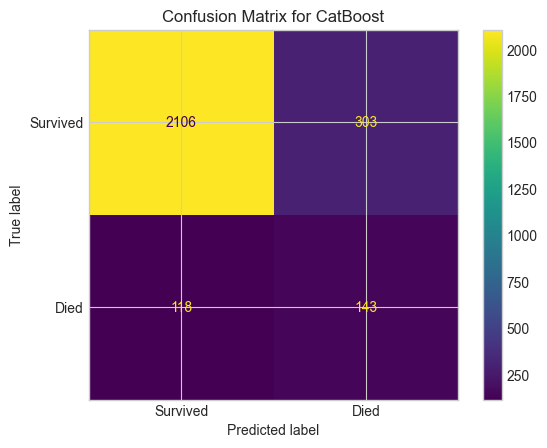

In [47]:
# Note: This is CatBoost for weighted, inbalanced Dataset
print(f"\n-== STEP 12.3: Detailed Report for CatBoost ==-")
y_pred_class = results['CatBoost']['model'].predict(X_test_processed)
print(classification_report(y_test, y_pred_class, target_names=['Survived', 'Died']))

print(f"\n-== STEP 12.4: Confusion Matrix ==-")
ConfusionMatrixDisplay.from_estimator(results['CatBoost']['model'],
                                      X_test_processed,
                                      y_test,
                                      display_labels=['Survived', 'Died'])
plt.title(f'Confusion Matrix for CatBoost')
plt.show()
